# Lab 7

**Tasks**

1. Find two time-series from any open-sources: one – with low noise-to-signal ratio and strong period (usual time series) and other – with high noise and not so explicit seasonality (noisy data, e.g. Dow-Jones index). For example, it can be some financial or economic values, weather measurements for several years, etc.
2. Implement Multi-step LSTM prediction model and ARIMA prediction model for both of your time series. The length of forecasting period should be not less then $\frac{1}{5}$ of time series’ length.
3. Evaluate MAPE error for your model (test set can be, for example, the last $\frac{1}{5}$ part of your series).
4. Compare the results of two models and choose the most appropriate one in each case.

In [151]:
%pylab inline
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from itertools import product
warnings.filterwarnings('ignore')
from pathlib import Path
import os
import math
import pmdarima as pm
from datetime import datetime
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import concat
from pandas import read_csv
from pandas import datetime
from pandas import Series
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from numpy import array

sns.set()

Populating the interactive namespace from numpy and matplotlib


## Data

**Low noise-to-signal ratio and strong period**

For the first dataset I choose **Dailty min temperatures in Melbourne** dataset. 
Url: https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia. The units are in degrees Celsius and there are 3650 observations. The source of the data is credited as the Australian Bureau of Meteorology.

**Noisy**

GSPC data

In [11]:
PATH_TO_DATA = Path("../data")

**MAPE implementation**

In [126]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**Utils**

In [146]:
def show_timeseries(timeseries, xlabel, ylabel, figsize=(12,6)):
    plt.figure(figsize=figsize)
    timeseries.plot()
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)

def dickey_fuller(time_series, diff=0, figsize=(15,10)):
    fig, ax = plt.subplots(4, 1, figsize=figsize)
    x = time_series[diff:]
    res = sm.tsa.seasonal_decompose(x=x)
    res.observed.plot(ax=ax[0])
    res.trend.plot(ax=ax[1])
    res.seasonal.plot(ax=ax[2])
    res.resid.plot(ax=ax[3])
    ax[1].set_ylabel('Trend')
    ax[2].set_ylabel('Seasonal')
    ax[3].set_ylabel('Residual')
    print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(x)[1])

def show_boxcox(timeseries_bc, lmbda, xlabel, ylabel, figsize=(15,7)):
    plt.figure(figsize=figsize)
    timeseries_bc.plot()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    print("Best Box-Cox parameter: %f" % lmbda)
    print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(timeseries_bc)[1])

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

def show_acf_pacf(time_series, diff, lags=30, figsize=(15,12)):
    fig, ax = plt.subplots(2, 1, figsize=figsize)
    x = time_series[diff:]
    sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax[0])
    sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax[1])

from tqdm import tqdm_notebook

def optimize_arima(time_series, params, s=0):
    results = []
    best_aic = float("inf")
    for param in tqdm_notebook(parameters_list):
        try:
            model=sm.tsa.statespace.SARIMAX(
                time_series, 
                order=(param[0], param[1], param[2]), 
                seasonal_order=(param[3], param[4], param[5], s)).fit(disp=-1)
        except ValueError:
            print(param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
            results.append([param, model.aic])
    print(best_aic)
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by = 'aic', ascending=True)
    return result_table

def show_fit(ts_actual, ts_model, diff_model, figsize=(15,7)):
    plt.figure(figsize=figsize)
    ts_actual.plot(color='b', lw=2)
    ts_model[diff_model:].plot(color='r')
    plt.ylabel('Index price')

def plot_arima_results(time_series, time_series_holdout, model, lam, s, d, n_steps, figsize=(15,10)):
    data = time_series.copy()
    data.columns = ['actual']
    data['model_values'] = invboxcox(model.fittedvalues, lam)
    data['model_values'][:s+d] = np.NaN
    prediction = invboxcox(model.predict(start=data.shape[0], end=data.shape[0]+len(time_series_holdout)), lam)
    error = mean_absolute_percentage_error(time_series_holdout, prediction)
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f"MAPE on prediction: {error:.2f}")
    ax.plot(prediction, color='r', label="model")
    ax.plot(time_series_holdout)
    ax.plot(data['actual'], label="actual")
    ax.legend()
    pylab.show()

def calculate_ARIMA(ns_order, ss_order):
    startTimeModel = datetime.now()
    aic_score, bic_score = float("inf"), float("inf")
    if (verbose): print('Trying to fit the model with parameters:', ns_order, ss_order)
    try:
        if (ss_order[3] == 0): model = SARIMAX(time_series, order=ns_order)
        else: model = SARIMAX(time_series, order=ns_order, seasonal_order=ss_order)
        grid_results = model.fit()
        aic_score = grid_results.aic
        bic_score = grid_results.bic
        print('Fit ARIMA: order=%s seasonal_order=%s; AIC=%.3f, BIC=%.3f, Fit time=%s' % 
              (ns_order, ss_order, aic_score, bic_score, (datetime.now() - startTimeModel)))
        return(aic_score, bic_score)
    except:
        return(float("inf"), float("inf"))

## EDA

### Timesries 1

In [44]:
min_temp = pd.read_csv(
    PATH_TO_DATA / "daily-min-temperatures.csv", 
    index_col=["Date"], 
    parse_dates=["Date"]
)[["Temp"]].asfreq('d')
min_temp.head()

Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8

In [55]:
min_temp = min_temp.fillna(0)

In [56]:
split_at = int(len(min_temp)*0.8)
min_temp_train, min_temp_test = min_temp[:split_at], min_temp[split_at:]

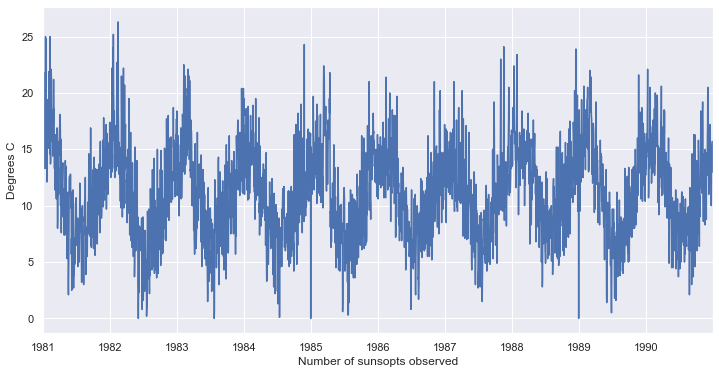

In [57]:
show_timeseries(min_temp['Temp'], 'Degrees C', 'Number of sunsopts observed')

**Density plots**

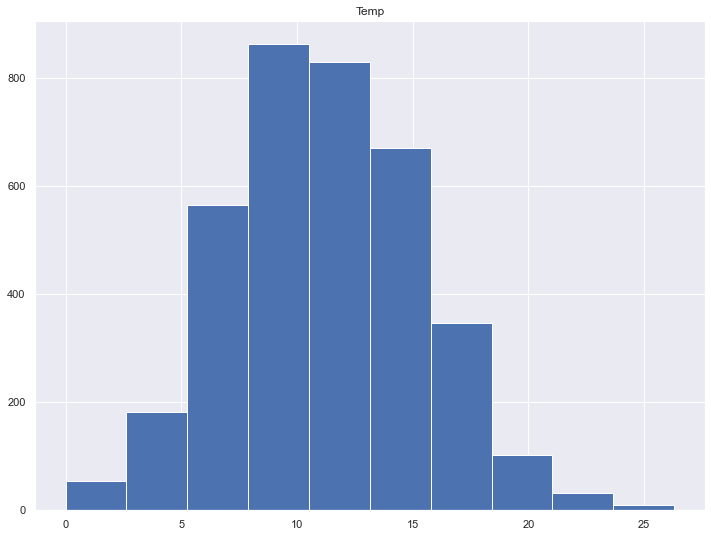

In [62]:
fig, ax = plt.subplots(figsize=(12,9))
min_temp.hist(ax=ax)
plt.show()

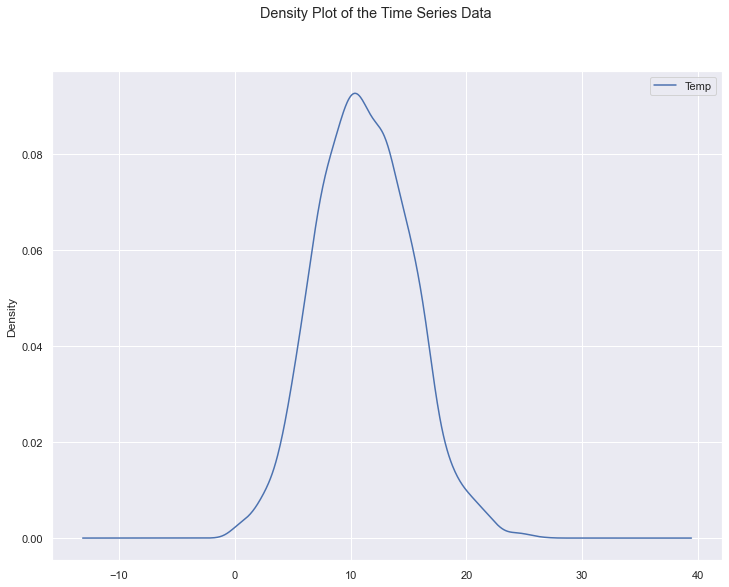

In [64]:
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Density Plot of the Time Series Data')
min_temp.plot(kind='kde', ax=ax)
plt.show()

**Box wiskers plots**

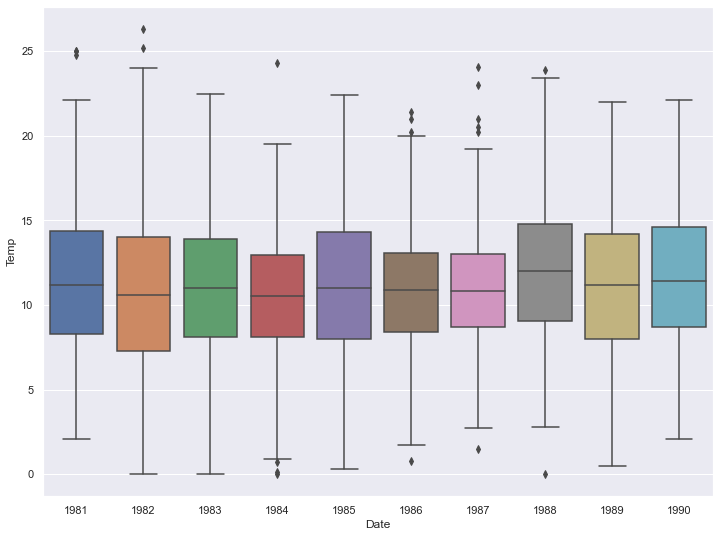

In [65]:
fig, ax = plt.subplots(figsize=(12,9))
squeezed = min_temp.squeeze()
sns.boxplot(squeezed.index.year, squeezed, ax=ax)
plt.show()

In [67]:
original_series = min_temp
resample = original_series.resample('W')
min_temp = resample.mean()
min_temp.head(10)

Temp
Date                 
1981-01-04  18.000000
1981-01-11  17.542857
1981-01-18  20.371429
1981-01-25  15.771429
1981-02-01  16.657143
1981-02-08  17.957143
1981-02-15  18.571429
1981-02-22  17.300000
1981-03-01  17.242857
1981-03-08  15.271429

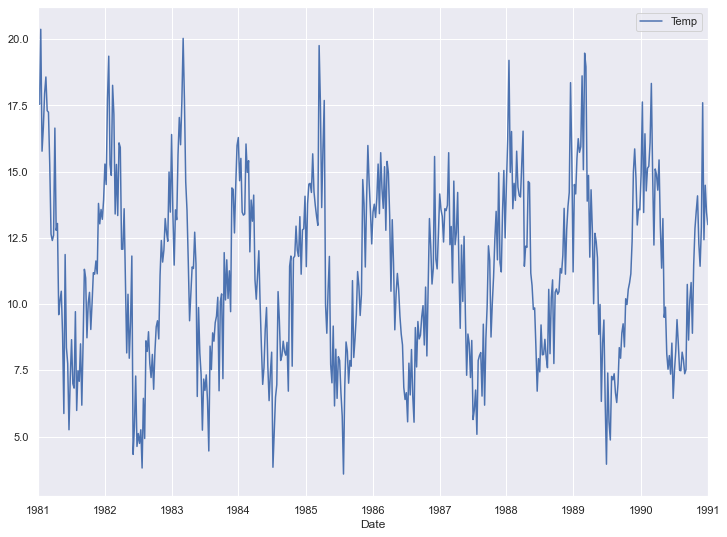

In [69]:
fig, ax = plt.subplots(figsize=(12,9))
min_temp.plot(ax=ax)
plt.show()

**Stationarity test**

In [70]:
result = adfuller(min_temp["Temp"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.445422
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


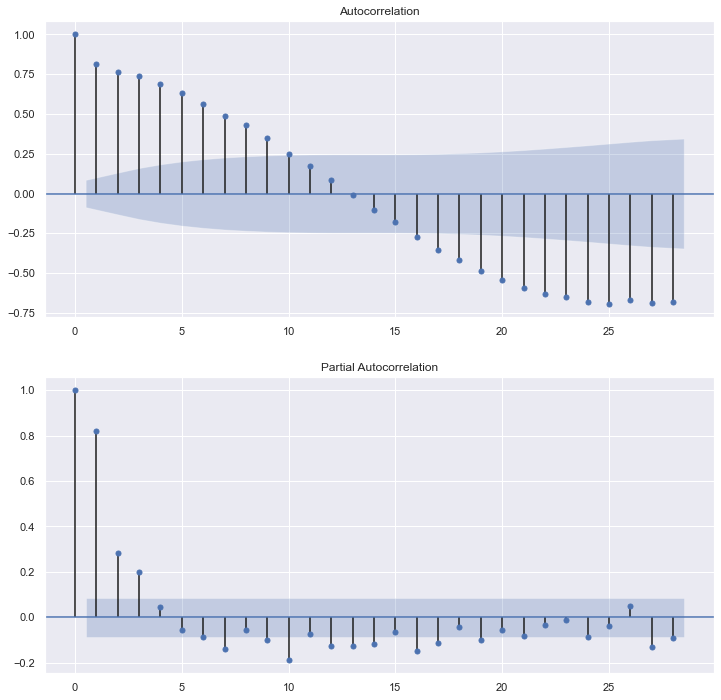

In [72]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(min_temp, ax=ax1)
plot_pacf(min_temp, ax=ax2)
plt.show()

**Test stationarity of deseasoned data**

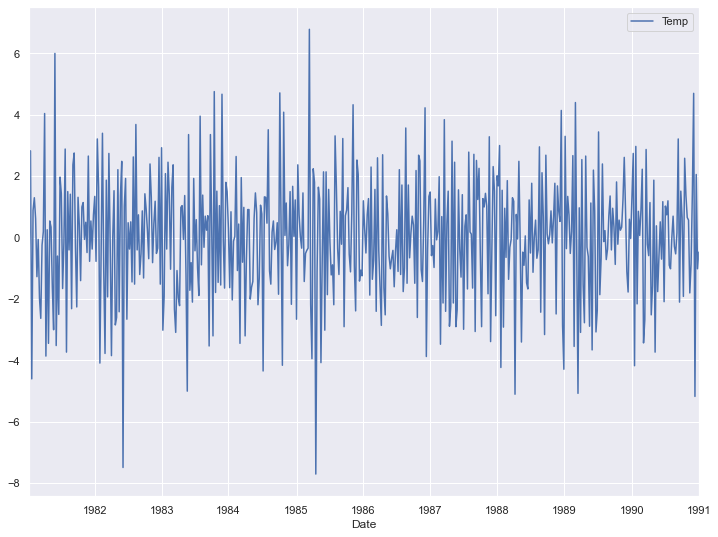

In [74]:
stationary_ns = min_temp.diff().dropna()

fig, ax = plt.subplots(figsize=(12,9))
stationary_ns.plot(ax=ax)
plt.show()

In [76]:
result = adfuller(stationary_ns["Temp"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.074424
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


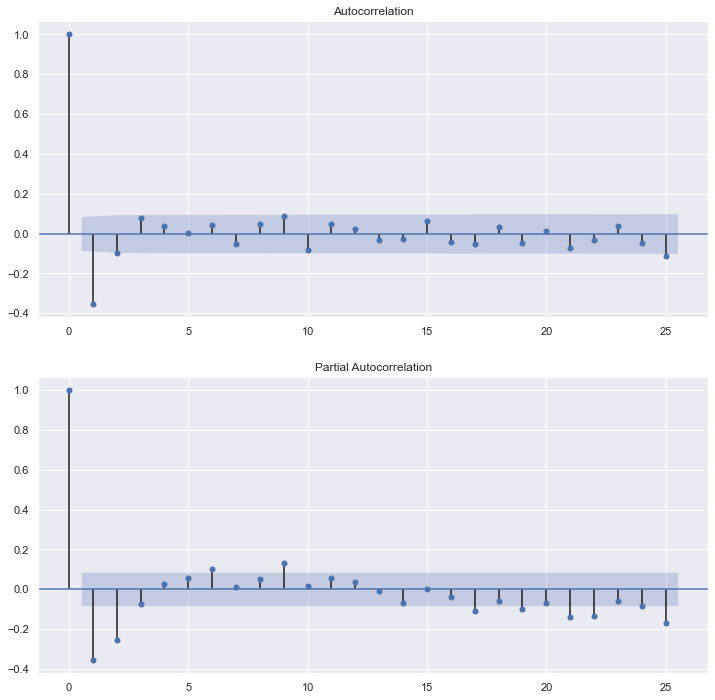

In [77]:
lags = 25
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(stationary_ns, lags=lags, ax=ax1)
plot_pacf(stationary_ns, lags=lags, ax=ax2)
plt.show()

**Seasonal decomposition**

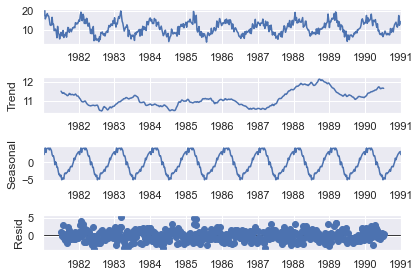

In [85]:
seasonal_decompose(min_temp, freq=52).plot();

**Detrended data**

In [86]:
N = 52
detrend = min_temp - min_temp.rolling(N).mean()
detrend = detrend.dropna()

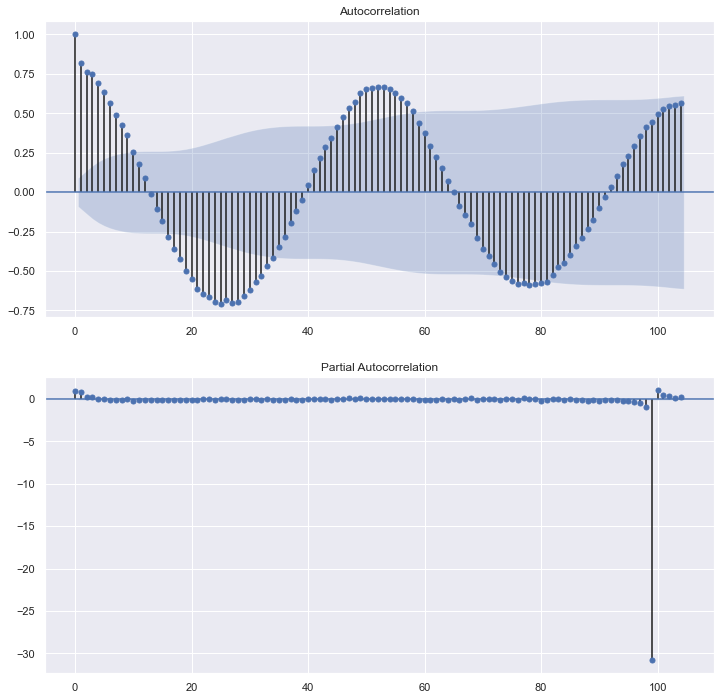

In [88]:
lag = 52 * 2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(detrend, lags=lag, ax=ax1)
plot_pacf(detrend, lags=lag, ax=ax2)
plt.show()

**Stationarity of seasonal**

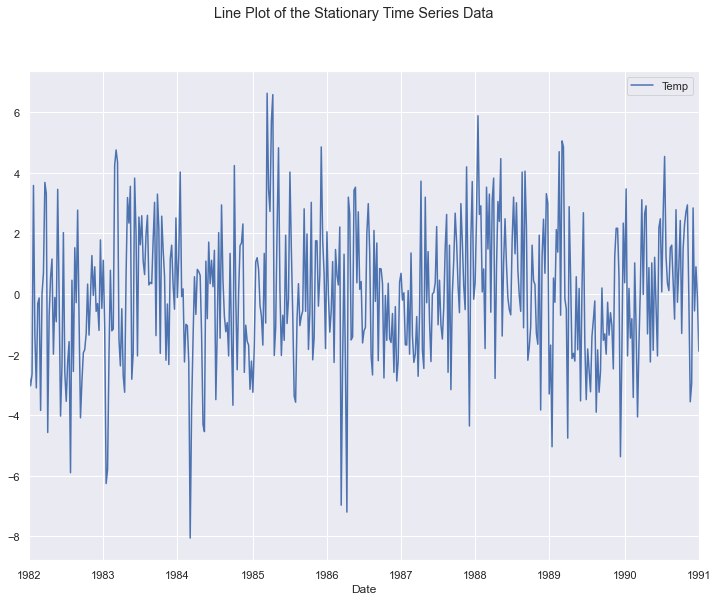

In [89]:
# Create a differenced series
stationary_ss = min_temp.diff(52).dropna()

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Time Series Data')
stationary_ss.plot(ax=ax)
plt.show()

In [91]:
result = adfuller(stationary_ss["Temp"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.348100
p-value: 0.000004
Critical Test Statistics Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


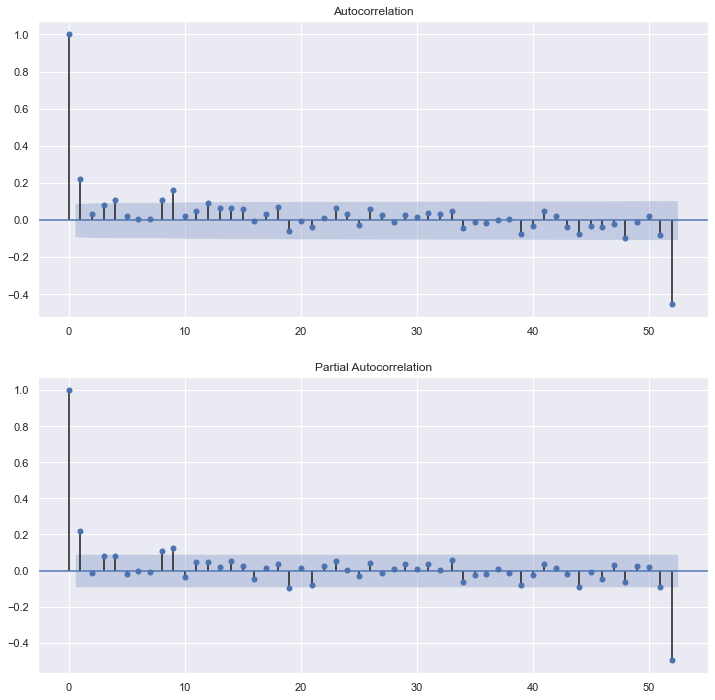

In [93]:
lags = 52
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(stationary_ss, lags=lags, ax=ax1)
plot_pacf(stationary_ss, lags=lags, ax=ax2)
plt.show()

Dickey-Fuller test: p=0.000229


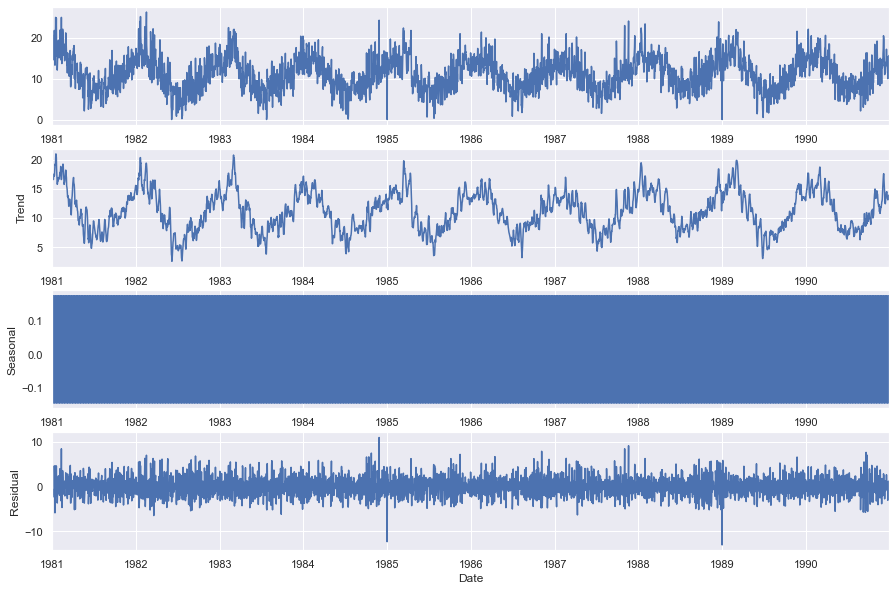

In [58]:
dickey_fuller(min_temp['Temp'])

### Noisy data

In [103]:
SP500_raw = pd.read_csv(
    PATH_TO_DATA / '^GSPC.csv',
    index_col=['Date'], 
    parse_dates=['Date'],
    dayfirst=False
)[['Open']]
idx = pd.date_range('2015-12-04', '2018-12-03')
SP500 = SP500_raw.reindex(idx, method='ffill')

In [104]:
split_at = int(len(SP500)*0.8)
SP500_train, SP500_test = SP500[:split_at], SP500[split_at:]

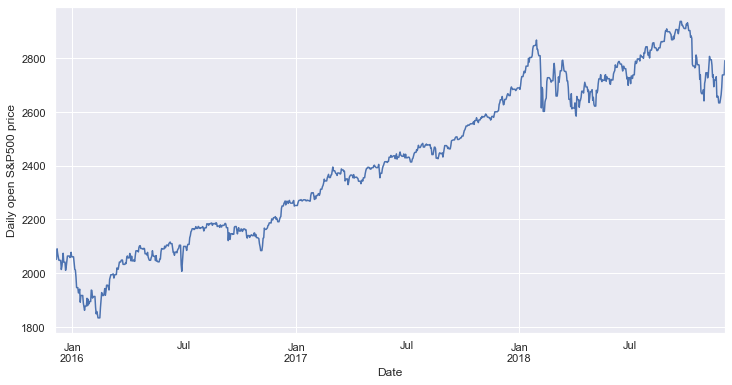

In [105]:
show_timeseries(SP500.Open, "Daily open S&P500 price", "Date")

Dickey-Fuller test: p=0.848331


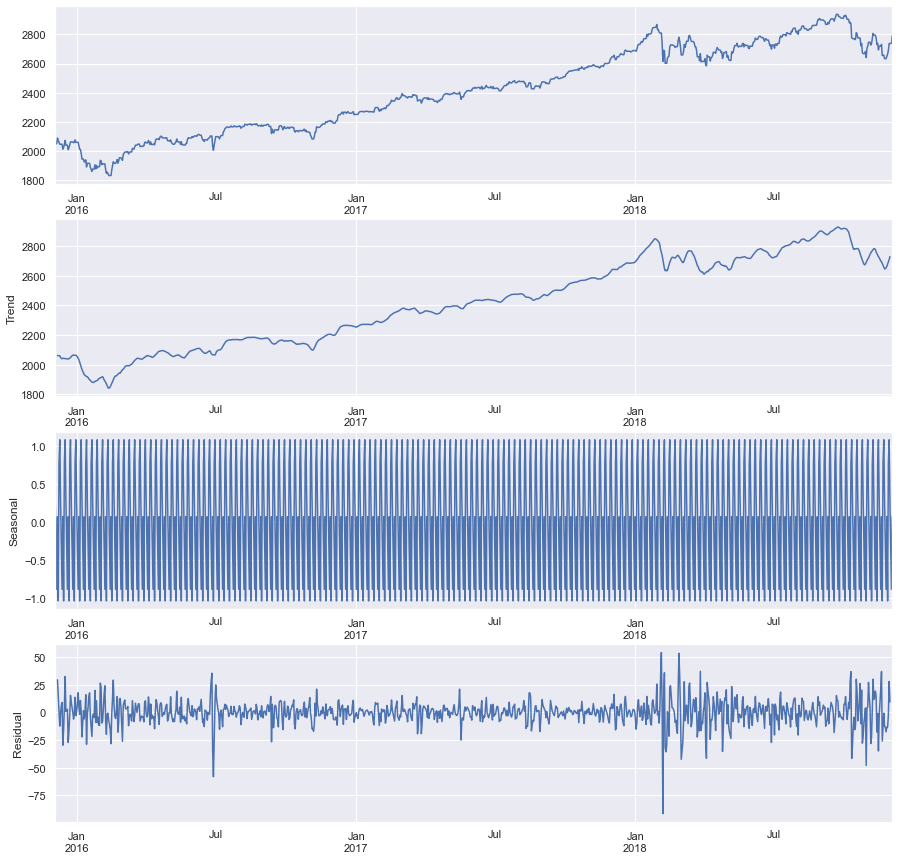

In [106]:
dickey_fuller(SP500.Open, figsize=(15,15))

**Density plots**

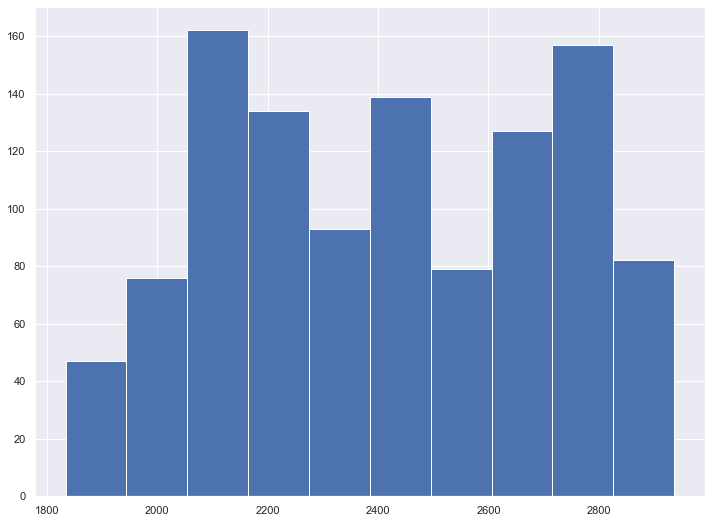

In [107]:
fig, ax = plt.subplots(figsize=(12,9))
SP500.Open.hist(ax=ax)
plt.show()

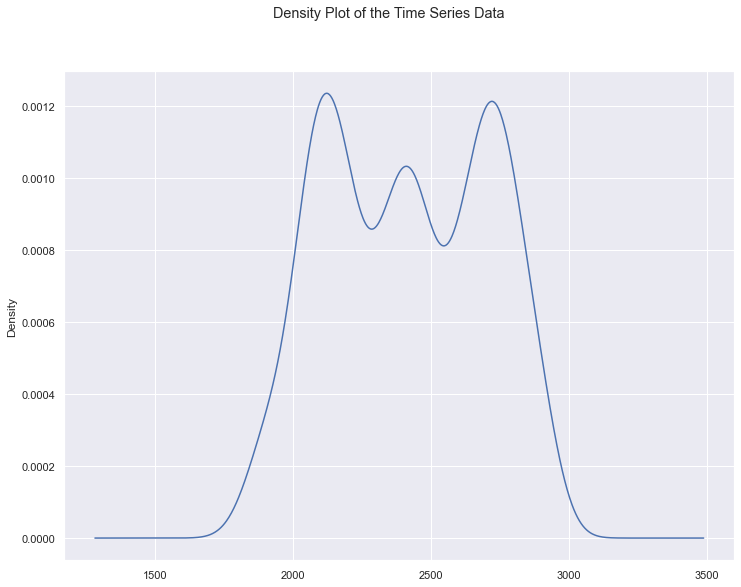

In [108]:
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Density Plot of the Time Series Data')
SP500.Open.plot(kind='kde', ax=ax)
plt.show()

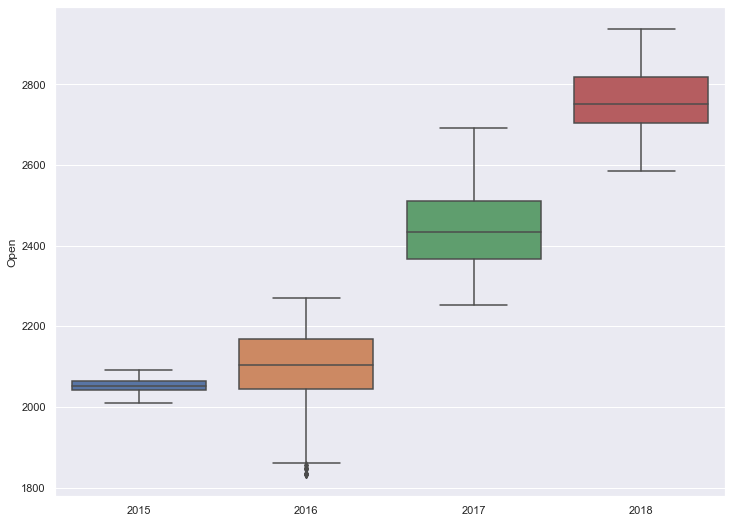

In [111]:
fig, ax = plt.subplots(figsize=(12,9))
squeezed = SP500.Open.squeeze()
sns.boxplot(squeezed.index.year, squeezed, ax=ax)
plt.show()

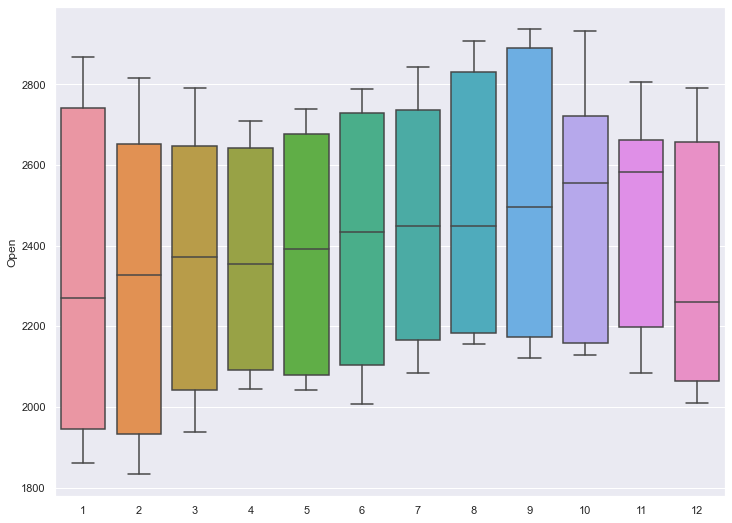

In [112]:
fig, ax = plt.subplots(figsize=(12,9))
squeezed = SP500.Open.squeeze()
sns.boxplot(squeezed.index.month, squeezed, ax=ax)
plt.show()

**Stationary transformation**

Best Box-Cox parameter: 0.845026
Dickey-Fuller test: p=0.847552


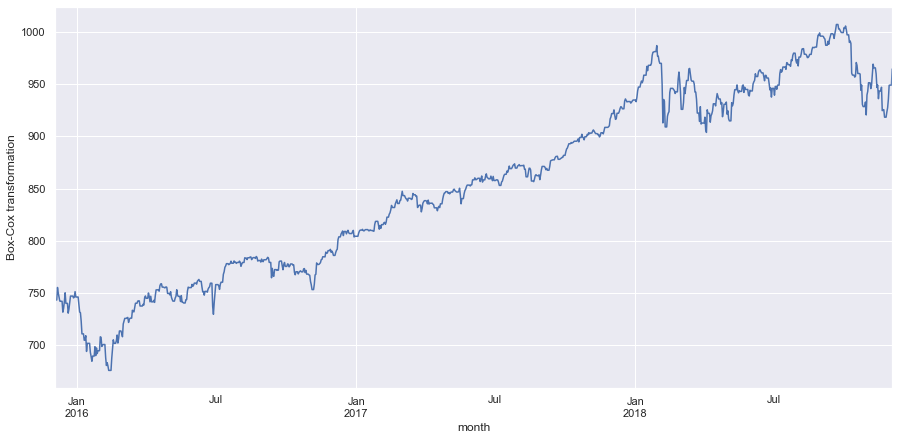

In [114]:
SP500['boxcox'], lmbda = stats.boxcox(SP500['Open'])
show_boxcox(SP500['boxcox'], lmbda, 'month', 'Box-Cox transformation')

Dickey-Fuller test: p=0.000000


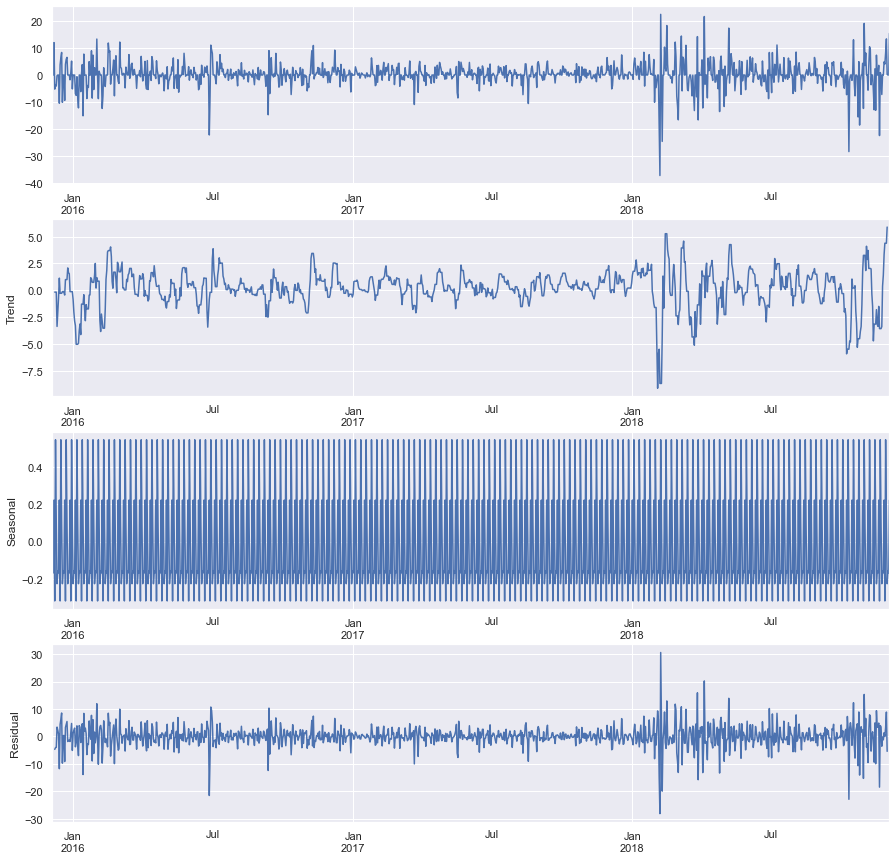

In [116]:
SP500['boxcox_d_1D'] = SP500.boxcox - SP500.boxcox.shift(1)
dickey_fuller(SP500['boxcox_d_1D'], diff=1, figsize=(15,15))

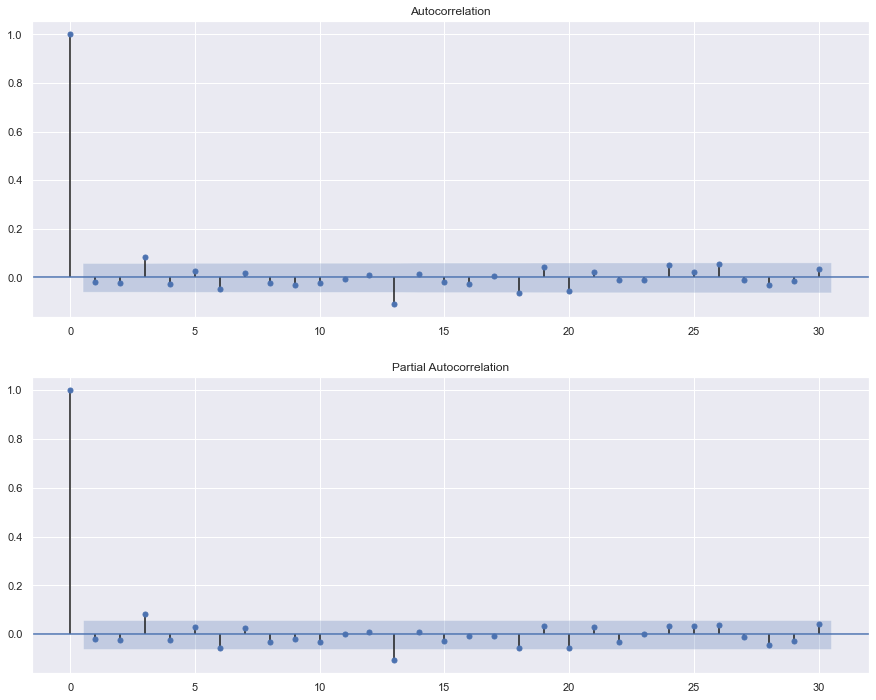

In [118]:
show_acf_pacf(SP500.boxcox_d_1D[1:], diff=1)

## (S)ARIMA

### Noisy

In [120]:
result_table = optimize_arima(SP500.boxcox, parameters_list, 0)


6374.425337704228


In [171]:
p, d, q, P, D, Q = result_table.parameters[0]
s = 0
best_model=sm.tsa.statespace.SARIMAX(SP500[:int(len(SP500)*0.8)].boxcox, 
                                     order=(p, d, q),
                                     seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 boxcox   No. Observations:                  876
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2490.507
Date:                Thu, 31 Dec 2020   AIC                           4983.013
Time:                        19:26:16   BIC                           4987.787
Sample:                    12-04-2015   HQIC                          4984.839
                         - 04-27-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        17.3693      0.303     57.335      0.000      16.776      17.963
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6678.43
Prob(Q):                              0.98   Pr

Student test: p=0.128565
Dickey-Fuller test: p=0.0000000000000000000000086


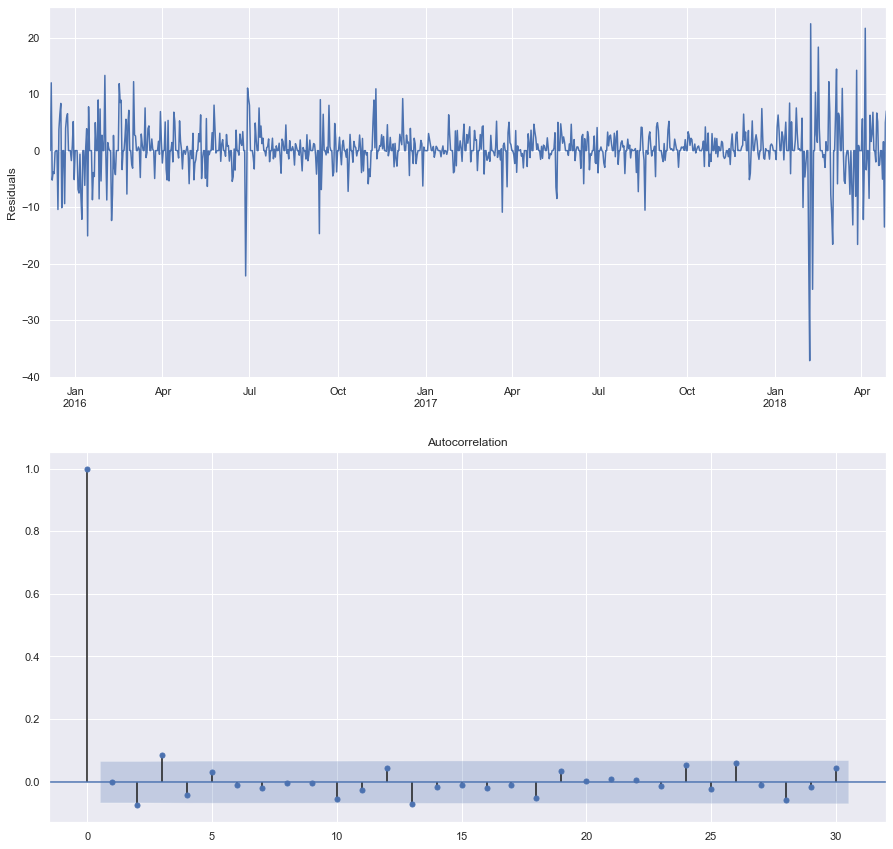

In [172]:
plt.figure(figsize=(15,15))
plt.subplot(211)
best_model.resid[d:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[d:], lags=30, ax=ax)

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[d:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[d:])[1])

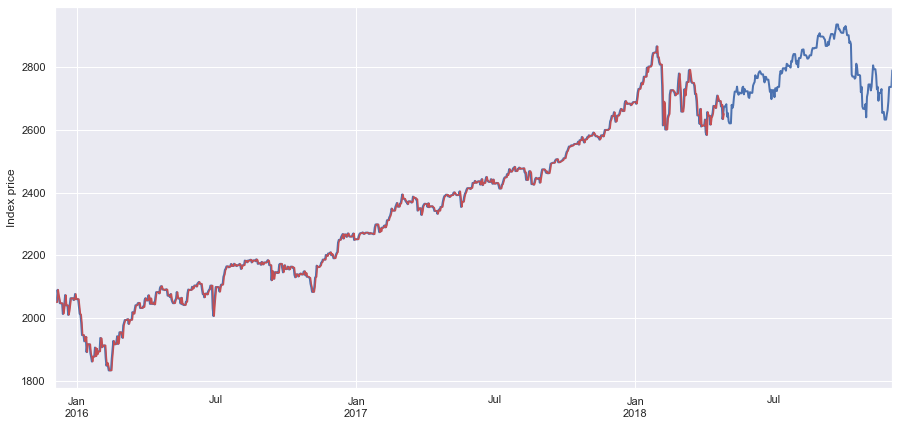

In [173]:
SP500['model'] = invboxcox(best_model.fittedvalues, lmbda)
show_fit(SP500['Open'], SP500['model'], 1)

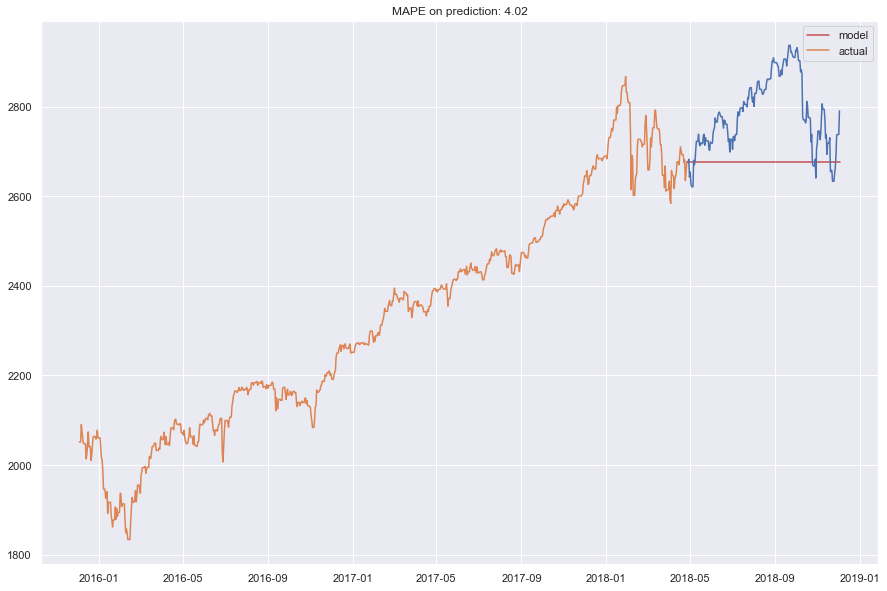

In [179]:
plot_arima_results(
    SP500_train[['Open']], 
    SP500_test['Open'], 
    best_model, 
    lmbda, 
    s, 
    d, 
    n_steps=len(SP500_test)
)

### Seasonal

**Baseline**

In [131]:
time_series = min_temp
target_col = "Temp"
seasonal_freq = 52

X = time_series.values
X = X.astype('float32')
train_pct = 0.70
train_size = int(len(X) * train_pct)
test_size = len(X) - train_size
train_ts, test_ts = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train_ts]
predictions = list()
for i in range(len(test_ts)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test_ts[i]
    history.append(obs)

rmse = math.sqrt(mean_squared_error(test_ts, predictions))
print('RMSE for the constant model is: %.3f' % rmse)

RMSE for the constant model is: 1.975


In [132]:
print('The suggested non-seasonal differencing term is:', pm.arima.ndiffs(train_ts))
if (seasonal_freq != 0): print('The suggested seasonal differencing term is:', pm.arima.nsdiffs(train_ts, m = seasonal_freq))

The suggested non-seasonal differencing term is: 0
The suggested seasonal differencing term is: 0


**Perform autogrid search for best params**

It took too long, so I interrupted it and removed the cell not to polute notebook

In [141]:
model = SARIMAX(min_temp, order=(1, 0, 2), seasonal_order=(0, 1, 1, 52))
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 Temp   No. Observations:                  523
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 52)   Log Likelihood                -948.644
Date:                              Thu, 31 Dec 2020   AIC                           1907.288
Time:                                      19:14:50   BIC                           1928.062
Sample:                                  01-04-1981   HQIC                          1915.460
                                       - 01-06-1991                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9018      0.064     14.186      0.000       0.777       1.026
ma.L1         -0.65

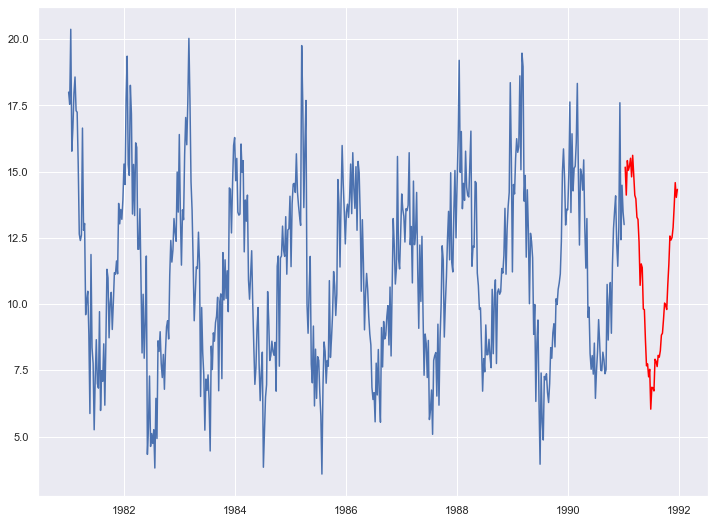

In [144]:
forecast = results.get_forecast(steps=50)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

plt.figure(figsize=(12,9))
plt.plot(time_series.index, time_series[target_col], label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')

plt.show()

## LSTM

**Common utils**

In [156]:
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        print(i)
        hist = model.fit(
            X, 
            y, 
            validation_split=0.1, 
            epochs=1, 
            batch_size=n_batch, 
            verbose=1, 
            shuffle=False
        )
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    return model,history_loss,history_val_loss

def forecast_lstm(model, X, n_batch):
    X = X.reshape(1, 1, len(X))
    forecast = model.predict(X, batch_size=n_batch)
    return [x for x in forecast[0, :]]

def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        forecast = forecast_lstm(model, X, n_batch)
        forecasts.append(forecast)
    return forecasts
 
def inverse_difference(last_ob, forecast):
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        inverted.append(inv_diff)
    return inverted

def train(ts, n_lag, n_seq, n_epochs, n_batch, n_neurons):
    scaler, train, test = prepare_data(ts, n_test, n_lag, n_seq)
    model, train_loss, val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
    forecast = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
    forecast = inverse_transform(ts, forecast, scaler, n_test+2)
    return model, train_loss, val_loss, forecast

def show_lstm_results(ts, ts_holdout, forecast, xlabel, ylabel, figsize=(15,10)):
    fig, ax = plt.subplots(figsize=figsize)
    plt.plot(ts[:].values, lw=2, label='actual')
    ax.plot([x + len(ts) for x in range(len(ts_holdout))],
            ts_holdout.values,
            lw=2,
            label='holdout')
    off_s = len(ts) - n_test + len(forecast) - 1
    off_e = off_s + len(forecast[0])
    forecast_xaxis = [x for x in range(off_s, off_e)]
    forecast_values = np.array(forecast[-1]).squeeze()
    ax.plot(forecast_xaxis, forecast_values, color='r', lw=2, label='model')
    
    error = mean_absolute_percentage_error(ts_holdout, forecast_values)
    ax.set_title(f"MAPE on prediction: {error:.2f}", fontsize=20)

    ax.set_ylabel(xlabel)
    ax.set_xlabel(ylabel)
    ax.legend(loc='best', fontsize=16)

def show_loss(train_loss, val_loss, title, figsize=(15,10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(train_loss, 'r', label='train')
    ax.plot(val_loss, 'b', label='val')
    ax.legend(loc='best')
    ax.set_title(title, fontsize=20)
    print(f'Train loss at the end: {train_loss[-1][0]:.2f}\nValidation loss at the end: {val_loss[-1][0]:.2f}')

### Noisy

In [168]:
n_lag = int(len(SP500_test) * 2)
n_seq = len(SP500_test)
n_test = 1
n_epochs = 60
n_batch = 1
n_neurons = 8

model_SP500, train_loss_SP500, val_loss_SP500, forecast_SP500 = train(
    ts=SP500_train,
    n_lag=n_lag,
    n_seq=n_seq,
    n_epochs=n_epochs,
    n_batch=n_batch,
    n_neurons=n_neurons
)

0
193/193 [==============================] - 1s 4ms/step - loss: 0.0235 - val_loss: 0.0372
1
193/193 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0372
2
193/193 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0372
3
193/193 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0372
4
193/193 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0372
5
193/193 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0372
6
193/193 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0372
7
193/193 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0372
8
193/193 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0372
9
193/193 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0372
10
193/193 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.037

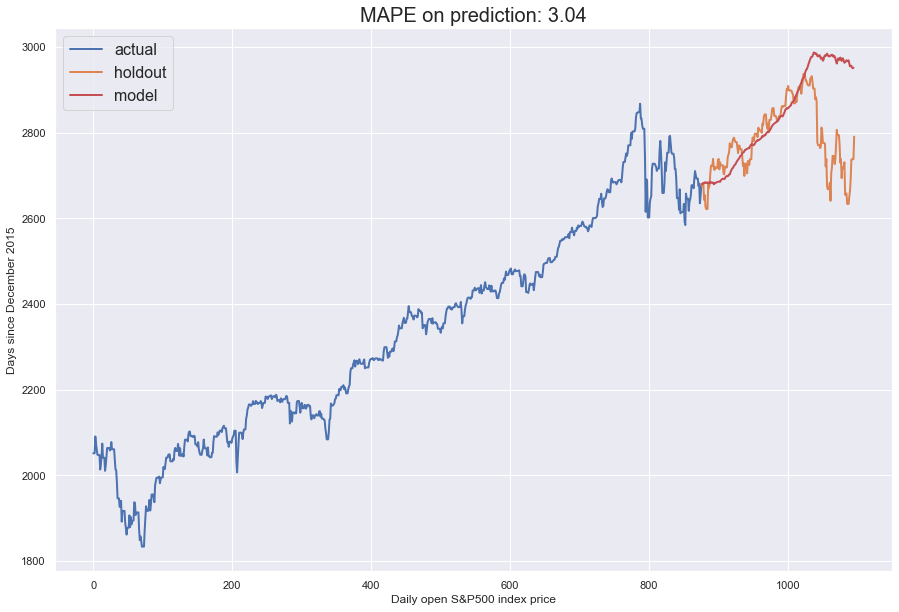

In [169]:
show_lstm_results(
    SP500_train,
    SP500_test['Open'],
    forecast_SP500, 
    xlabel='Days since December 2015', 
    ylabel='Daily open S&P500 index price'
)

### Seasonal

In [187]:
n_lag = int(len(min_temp_test) * 2)
n_seq = len(min_temp_test)
n_test = 1
n_epochs = 120
n_batch = 1
n_neurons = 8

model_min_temp, train_loss_min_temp, val_loss_min_temp, forecast_min_temp = train(
    ts=min_temp_train,
    n_lag=n_lag,
    n_seq=n_seq,
    n_epochs=n_epochs,
    n_batch=n_batch,
    n_neurons=n_neurons
)

0
654/654 [==============================] - 1s 2ms/step - loss: 0.0340 - val_loss: 0.0336
1
654/654 [==============================] - 1s 1ms/step - loss: 0.0331 - val_loss: 0.0337
2
654/654 [==============================] - 1s 1ms/step - loss: 0.0329 - val_loss: 0.0337
3
654/654 [==============================] - 1s 2ms/step - loss: 0.0327 - val_loss: 0.0337
4
654/654 [==============================] - 1s 1ms/step - loss: 0.0324 - val_loss: 0.0337
5
654/654 [==============================] - 1s 1ms/step - loss: 0.0322 - val_loss: 0.0337
6
654/654 [==============================] - 1s 1ms/step - loss: 0.0321 - val_loss: 0.0337
7
654/654 [==============================] - 1s 1ms/step - loss: 0.0320 - val_loss: 0.0337
8
654/654 [==============================] - 1s 1ms/step - loss: 0.0319 - val_loss: 0.0338
9
654/654 [==============================] - 1s 1ms/step - loss: 0.0319 - val_loss: 0.0337
10
654/654 [==============================] - 1s 1ms/step - loss: 0.0318 - val_loss: 0.033

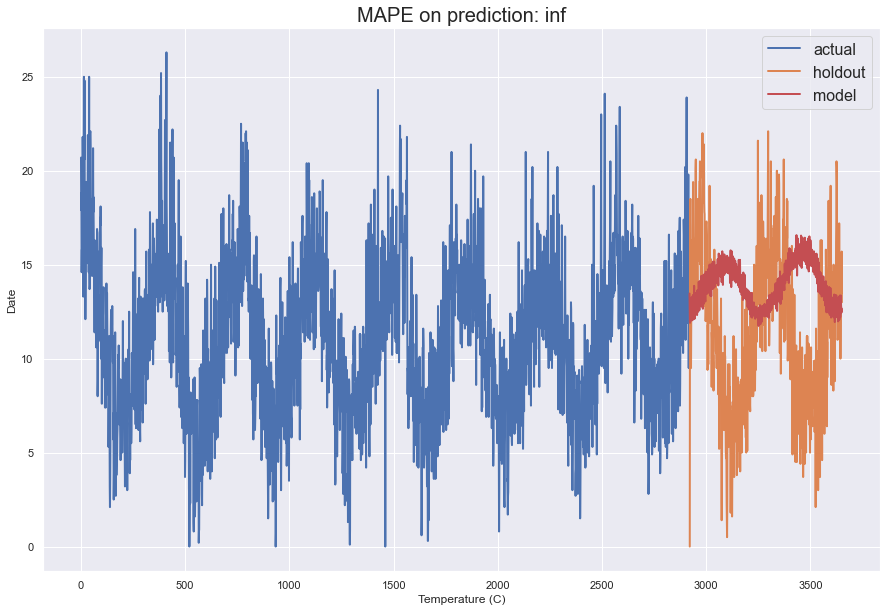

In [188]:
show_lstm_results(
    min_temp_train,
    min_temp_test["Temp"],
    forecast_min_temp, 
    xlabel='Date', 
    ylabel='Temperature (C)'
)

## Conclusion

For the noisy data ARIMA only managed to get sensible constant prediction, but for the seasonal data it performed better. LSTMs didn't really work that well for me this time, the results are not totally off, but were not usefull for seasonal data. As for the noisy data it showed better results than ARIMA, but they are not good enough in the long term.

As expected LSTM is generally better in very noisy TS, however, when timeseries is not so complex and can be well represented by a series of equations in ARIMA it workds better.

However, one must note also how much more manual work has to be done in case of ARIMA that is dependent on the TS data to get good results, whereas with LSTM you can share the model almost without any manual work. The catch here is that ARIMA gives somewhat interpretable results. In the end of the day "better" suited algorithm really depends not only on the data, but how the model will be used  